In [1]:
from environments import ZeroDCleanupEnv
from agents import CentralizedQAgent
import numpy as np
from collections import defaultdict
import torch
import sys
from tqdm import tqdm

2023-11-21 15:25:31,788	WARNING deprecation.py:50 -- DeprecationWarning: `DirectStepOptimizer` has been deprecated. This will raise an error in the future!


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
np.set_printoptions(threshold=sys.maxsize)

cpu


In [3]:
num_agents = 10
agent_ids = [str(i) for i in range(num_agents)]
reward_multiplier = 10

In [4]:
pp = False
verbose = False

In [5]:
num_episodes = 200
verbose_episode = num_episodes - 1
max_steps_per_episode = 1000
state_dim = 4
action_dim = 2

In [6]:
thresholdDepletion = 0.4
thresholdRestoration = 0.0
wasteSpawnProbability = 0.5
appleRespawnProbability = 0.05
dirt_multiplier = 10

area = 150

In [7]:
lr = 0.01
gamma = 0.99
epsilon = 0.5
epsilon_decay = 0.9999
epsilon_min = 0.05
batch_size = 128

In [8]:
env = ZeroDCleanupEnv(agent_ids, 
                      num_agents=num_agents, 
                      area=area, 
                      thresholdDepletion=thresholdDepletion,
                      thresholdRestoration=thresholdRestoration,
                      wasteSpawnProbability=wasteSpawnProbability,
                      appleRespawnProbability=appleRespawnProbability,
                      dirt_multiplier=dirt_multiplier)

agentCoordinator = CentralizedQAgent(device=device,
                                     num_agents=num_agents,
                                     action_size=action_dim,
                                     state_dim=state_dim,
                                     lr=lr,
                                     gamma=gamma,
                                     epsilon=epsilon,
                                     epsilon_decay=epsilon_decay,
                                     epsilon_min=epsilon_min,
                                     batch_size=batch_size,
                                     q_layers=[
                                         (state_dim, 64),
                                         (64, 32),
                                         (32, 32),
                                         (32, action_dim * num_agents)
                                     ],
                                     verbose=False)

In [9]:
ending_ep_rewards = []
weight_graph = defaultdict(list)

In [10]:
import uuid
import os

if not os.path.exists("results"):
    os.mkdir("results")

test_id = uuid.uuid4()
os.mkdir("results/q_simple_" + str(test_id))
f = open("results/q_simple_" + str(test_id) + "/logs.txt", "x")

In [11]:
for episode in range(num_episodes):
    print(f"========= Episode {episode} =========")
    f.write(f"========= Episode {episode} =========\n")

    states, info = env.reset()
    #states = np.concatenate(list(states.values()), axis=0)
    state = states[agent_ids[0]]

    print(f"info: {info}")
    f.write(f"info: {info}\n")

    for step in tqdm(range(max_steps_per_episode)):
        actions_list = agentCoordinator.act(state)[0]
        actions = {agent_id: actions_list[i] for i, agent_id in enumerate(agent_ids)}
        next_states, rewards, dones, _, info = env.step(actions)
        #next_states = np.concatenate(list(next_states.values()), axis=0)
        next_state = next_states[agent_ids[0]]
        reward = sum(rewards.values())
        #reward_graph.append(reward)
        agentCoordinator.step(state, actions_list, reward, next_state)

        if episode > verbose_episode:
            print(f"========= Step {step} =========")
            print(f"info: {info}")
            f.write(f"========= Step {step} =========\n")
            f.write(f"info: {info}\n")

        state = next_state

        if dones["__all__"]:
            break 

    ending_reward = info["total_apple_consumed"]

    print(f"ending reward: {ending_reward}")
    #print(f"reward graph: {reward_graph}")
    print(f"========= End of Episode {episode} =========")
    
    f.write(f"ending reward: {ending_reward}\n")
    #f.write(f"reward graph: {reward_graph}\n")
    f.write(f"========= End of Episode {episode} =========\n")

    ending_ep_rewards.append(ending_reward)

    if ending_reward > 5000 and ending_ep_rewards[-2] > 5000 and agentCoordinator.epsilon < 0.1:
        break

    

torch.save(agentCoordinator.q_network.state_dict(), "results/q_simple_" + str(test_id) + "/q_network.pt")

        

========= Episode 0 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


 13%|█▎        | 129/1000 [00:00<00:01, 655.09it/s]

100%|█████████▉| 999/1000 [00:01<00:00, 544.95it/s]


ending reward: 2632
========= End of Episode 0 =========
========= Episode 1 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 565.85it/s]


ending reward: 2644
========= End of Episode 1 =========
========= Episode 2 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 559.07it/s]


ending reward: 2607
========= End of Episode 2 =========
========= Episode 3 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 702.84it/s]


ending reward: 2681
========= End of Episode 3 =========
========= Episode 4 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 550.63it/s]


ending reward: 2707
========= End of Episode 4 =========
========= Episode 5 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 782.10it/s]


ending reward: 2676
========= End of Episode 5 =========
========= Episode 6 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 693.44it/s]


ending reward: 2693
========= End of Episode 6 =========
========= Episode 7 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 842.12it/s]


ending reward: 2688
========= End of Episode 7 =========
========= Episode 8 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 855.61it/s]


ending reward: 2798
========= End of Episode 8 =========
========= Episode 9 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 816.75it/s]


ending reward: 2627
========= End of Episode 9 =========
========= Episode 10 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 843.10it/s]


ending reward: 2575
========= End of Episode 10 =========
========= Episode 11 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 852.72it/s]


ending reward: 2578
========= End of Episode 11 =========
========= Episode 12 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 858.83it/s]


ending reward: 2508
========= End of Episode 12 =========
========= Episode 13 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 784.94it/s]


ending reward: 2577
========= End of Episode 13 =========
========= Episode 14 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 782.08it/s]


ending reward: 2477
========= End of Episode 14 =========
========= Episode 15 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 803.01it/s]


ending reward: 2378
========= End of Episode 15 =========
========= Episode 16 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 812.46it/s]


ending reward: 2423
========= End of Episode 16 =========
========= Episode 17 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 720.80it/s]


ending reward: 2192
========= End of Episode 17 =========
========= Episode 18 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 701.24it/s]


ending reward: 1938
========= End of Episode 18 =========
========= Episode 19 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 794.44it/s]


ending reward: 1970
========= End of Episode 19 =========
========= Episode 20 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 824.76it/s]


ending reward: 1887
========= End of Episode 20 =========
========= Episode 21 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 743.46it/s]


ending reward: 1661
========= End of Episode 21 =========
========= Episode 22 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 794.19it/s]


ending reward: 1052
========= End of Episode 22 =========
========= Episode 23 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 777.21it/s]


ending reward: 1130
========= End of Episode 23 =========
========= Episode 24 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 784.29it/s]


ending reward: 537
========= End of Episode 24 =========
========= Episode 25 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 753.99it/s]


ending reward: 766
========= End of Episode 25 =========
========= Episode 26 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 796.03it/s]


ending reward: 302
========= End of Episode 26 =========
========= Episode 27 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 788.26it/s]


ending reward: 301
========= End of Episode 27 =========
========= Episode 28 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 738.41it/s]


ending reward: 225
========= End of Episode 28 =========
========= Episode 29 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 754.55it/s]


ending reward: 217
========= End of Episode 29 =========
========= Episode 30 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 783.16it/s]


ending reward: 256
========= End of Episode 30 =========
========= Episode 31 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 803.85it/s]


ending reward: 193
========= End of Episode 31 =========
========= Episode 32 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 717.06it/s]


ending reward: 168
========= End of Episode 32 =========
========= Episode 33 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 744.41it/s]


ending reward: 230
========= End of Episode 33 =========
========= Episode 34 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 813.23it/s]


ending reward: 323
========= End of Episode 34 =========
========= Episode 35 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 811.40it/s]


ending reward: 351
========= End of Episode 35 =========
========= Episode 36 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 776.31it/s]


ending reward: 310
========= End of Episode 36 =========
========= Episode 37 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 667.67it/s]


ending reward: 155
========= End of Episode 37 =========
========= Episode 38 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 758.05it/s]


ending reward: 111
========= End of Episode 38 =========
========= Episode 39 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 649.64it/s]


ending reward: 93
========= End of Episode 39 =========
========= Episode 40 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 736.14it/s]


ending reward: 170
========= End of Episode 40 =========
========= Episode 41 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 807.41it/s]


ending reward: 213
========= End of Episode 41 =========
========= Episode 42 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 751.37it/s]


ending reward: 183
========= End of Episode 42 =========
========= Episode 43 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 757.35it/s]


ending reward: 157
========= End of Episode 43 =========
========= Episode 44 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 747.49it/s]


ending reward: 300
========= End of Episode 44 =========
========= Episode 45 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 713.08it/s]


ending reward: 244
========= End of Episode 45 =========
========= Episode 46 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 772.18it/s]


ending reward: 283
========= End of Episode 46 =========
========= Episode 47 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 791.31it/s]


ending reward: 601
========= End of Episode 47 =========
========= Episode 48 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 818.61it/s]


ending reward: 435
========= End of Episode 48 =========
========= Episode 49 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 808.12it/s]


ending reward: 330
========= End of Episode 49 =========
========= Episode 50 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 820.75it/s]


ending reward: 219
========= End of Episode 50 =========
========= Episode 51 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 836.96it/s]


ending reward: 338
========= End of Episode 51 =========
========= Episode 52 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 822.10it/s]


ending reward: 142
========= End of Episode 52 =========
========= Episode 53 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 778.22it/s]


ending reward: 135
========= End of Episode 53 =========
========= Episode 54 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 779.67it/s]


ending reward: 132
========= End of Episode 54 =========
========= Episode 55 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 794.78it/s]


ending reward: 171
========= End of Episode 55 =========
========= Episode 56 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 779.29it/s]


ending reward: 74
========= End of Episode 56 =========
========= Episode 57 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 812.65it/s]


ending reward: 635
========= End of Episode 57 =========
========= Episode 58 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 746.48it/s]


ending reward: 1009
========= End of Episode 58 =========
========= Episode 59 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 801.99it/s]


ending reward: 902
========= End of Episode 59 =========
========= Episode 60 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 795.38it/s]


ending reward: 762
========= End of Episode 60 =========
========= Episode 61 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 733.64it/s]


ending reward: 728
========= End of Episode 61 =========
========= Episode 62 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 753.86it/s]


ending reward: 437
========= End of Episode 62 =========
========= Episode 63 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 785.27it/s]


ending reward: 240
========= End of Episode 63 =========
========= Episode 64 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 699.21it/s]


ending reward: 122
========= End of Episode 64 =========
========= Episode 65 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 812.51it/s]


ending reward: 102
========= End of Episode 65 =========
========= Episode 66 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 780.61it/s]


ending reward: 66
========= End of Episode 66 =========
========= Episode 67 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 793.55it/s]


ending reward: 64
========= End of Episode 67 =========
========= Episode 68 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 756.62it/s]


ending reward: 54
========= End of Episode 68 =========
========= Episode 69 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 804.48it/s]


ending reward: 536
========= End of Episode 69 =========
========= Episode 70 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 670.91it/s]


ending reward: 2621
========= End of Episode 70 =========
========= Episode 71 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 760.38it/s]


ending reward: 2618
========= End of Episode 71 =========
========= Episode 72 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 712.71it/s]


ending reward: 2693
========= End of Episode 72 =========
========= Episode 73 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 721.39it/s]


ending reward: 2599
========= End of Episode 73 =========
========= Episode 74 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 786.87it/s]


ending reward: 2705
========= End of Episode 74 =========
========= Episode 75 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 731.57it/s]


ending reward: 2494
========= End of Episode 75 =========
========= Episode 76 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 781.90it/s]


ending reward: 2448
========= End of Episode 76 =========
========= Episode 77 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 799.67it/s]


ending reward: 2284
========= End of Episode 77 =========
========= Episode 78 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 801.25it/s]


ending reward: 2068
========= End of Episode 78 =========
========= Episode 79 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 776.94it/s]


ending reward: 1662
========= End of Episode 79 =========
========= Episode 80 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 792.19it/s]


ending reward: 1115
========= End of Episode 80 =========
========= Episode 81 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 736.54it/s]


ending reward: 863
========= End of Episode 81 =========
========= Episode 82 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 762.39it/s]


ending reward: 1014
========= End of Episode 82 =========
========= Episode 83 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 678.27it/s]


ending reward: 489
========= End of Episode 83 =========
========= Episode 84 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 782.91it/s]


ending reward: 364
========= End of Episode 84 =========
========= Episode 85 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 786.58it/s]


ending reward: 268
========= End of Episode 85 =========
========= Episode 86 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 718.57it/s]


ending reward: 187
========= End of Episode 86 =========
========= Episode 87 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 779.22it/s]


ending reward: 220
========= End of Episode 87 =========
========= Episode 88 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 765.78it/s]


ending reward: 141
========= End of Episode 88 =========
========= Episode 89 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 801.45it/s]


ending reward: 142
========= End of Episode 89 =========
========= Episode 90 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 767.63it/s]


ending reward: 377
========= End of Episode 90 =========
========= Episode 91 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 833.61it/s]


ending reward: 1117
========= End of Episode 91 =========
========= Episode 92 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 780.49it/s]


ending reward: 969
========= End of Episode 92 =========
========= Episode 93 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 801.45it/s]


ending reward: 936
========= End of Episode 93 =========
========= Episode 94 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 829.61it/s]


ending reward: 925
========= End of Episode 94 =========
========= Episode 95 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 817.46it/s]


ending reward: 999
========= End of Episode 95 =========
========= Episode 96 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 785.49it/s]


ending reward: 1122
========= End of Episode 96 =========
========= Episode 97 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 825.80it/s]


ending reward: 705
========= End of Episode 97 =========
========= Episode 98 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 773.67it/s]


ending reward: 772
========= End of Episode 98 =========
========= Episode 99 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 842.01it/s]


ending reward: 579
========= End of Episode 99 =========
========= Episode 100 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 850.10it/s]


ending reward: 795
========= End of Episode 100 =========
========= Episode 101 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 775.43it/s]


ending reward: 461
========= End of Episode 101 =========
========= Episode 102 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 831.66it/s]


ending reward: 543
========= End of Episode 102 =========
========= Episode 103 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 839.89it/s]


ending reward: 288
========= End of Episode 103 =========
========= Episode 104 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 854.54it/s]


ending reward: 146
========= End of Episode 104 =========
========= Episode 105 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 700.16it/s]


ending reward: 514
========= End of Episode 105 =========
========= Episode 106 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 791.22it/s]


ending reward: 473
========= End of Episode 106 =========
========= Episode 107 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 821.05it/s]


ending reward: 473
========= End of Episode 107 =========
========= Episode 108 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 836.63it/s]


ending reward: 465
========= End of Episode 108 =========
========= Episode 109 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 842.90it/s]


ending reward: 482
========= End of Episode 109 =========
========= Episode 110 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 870.76it/s]


ending reward: 313
========= End of Episode 110 =========
========= Episode 111 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 841.14it/s]


ending reward: 423
========= End of Episode 111 =========
========= Episode 112 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 805.51it/s]


ending reward: 855
========= End of Episode 112 =========
========= Episode 113 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 860.87it/s]


ending reward: 1062
========= End of Episode 113 =========
========= Episode 114 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 839.86it/s]


ending reward: 494
========= End of Episode 114 =========
========= Episode 115 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 823.01it/s]


ending reward: 167
========= End of Episode 115 =========
========= Episode 116 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 851.91it/s]


ending reward: 439
========= End of Episode 116 =========
========= Episode 117 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 844.14it/s]


ending reward: 468
========= End of Episode 117 =========
========= Episode 118 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 800.39it/s]


ending reward: 1127
========= End of Episode 118 =========
========= Episode 119 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 850.72it/s]


ending reward: 987
========= End of Episode 119 =========
========= Episode 120 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 862.57it/s]


ending reward: 1084
========= End of Episode 120 =========
========= Episode 121 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 850.32it/s]


ending reward: 608
========= End of Episode 121 =========
========= Episode 122 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 808.77it/s]


ending reward: 636
========= End of Episode 122 =========
========= Episode 123 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 780.90it/s]


ending reward: 739
========= End of Episode 123 =========
========= Episode 124 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 866.15it/s]


ending reward: 1789
========= End of Episode 124 =========
========= Episode 125 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 816.83it/s]


ending reward: 1642
========= End of Episode 125 =========
========= Episode 126 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 747.92it/s]


ending reward: 1389
========= End of Episode 126 =========
========= Episode 127 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 793.80it/s]


ending reward: 1900
========= End of Episode 127 =========
========= Episode 128 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 825.01it/s]


ending reward: 1382
========= End of Episode 128 =========
========= Episode 129 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 788.89it/s]


ending reward: 908
========= End of Episode 129 =========
========= Episode 130 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 819.45it/s]


ending reward: 581
========= End of Episode 130 =========
========= Episode 131 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 712.42it/s]


ending reward: 370
========= End of Episode 131 =========
========= Episode 132 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 838.36it/s]


ending reward: 250
========= End of Episode 132 =========
========= Episode 133 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 802.23it/s]


ending reward: 591
========= End of Episode 133 =========
========= Episode 134 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 811.19it/s]


ending reward: 813
========= End of Episode 134 =========
========= Episode 135 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 833.06it/s]


ending reward: 515
========= End of Episode 135 =========
========= Episode 136 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 743.40it/s]


ending reward: 210
========= End of Episode 136 =========
========= Episode 137 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 802.19it/s]


ending reward: 641
========= End of Episode 137 =========
========= Episode 138 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 753.62it/s]


ending reward: 644
========= End of Episode 138 =========
========= Episode 139 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 793.22it/s]


ending reward: 931
========= End of Episode 139 =========
========= Episode 140 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 708.66it/s]


ending reward: 840
========= End of Episode 140 =========
========= Episode 141 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 699.72it/s]


ending reward: 773
========= End of Episode 141 =========
========= Episode 142 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 694.87it/s]


ending reward: 986
========= End of Episode 142 =========
========= Episode 143 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 787.74it/s]


ending reward: 701
========= End of Episode 143 =========
========= Episode 144 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 759.16it/s]


ending reward: 494
========= End of Episode 144 =========
========= Episode 145 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 813.07it/s]


ending reward: 323
========= End of Episode 145 =========
========= Episode 146 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 829.90it/s]


ending reward: 309
========= End of Episode 146 =========
========= Episode 147 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 825.38it/s]


ending reward: 376
========= End of Episode 147 =========
========= Episode 148 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 839.93it/s]


ending reward: 608
========= End of Episode 148 =========
========= Episode 149 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 838.59it/s]


ending reward: 469
========= End of Episode 149 =========
========= Episode 150 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 801.61it/s]


ending reward: 618
========= End of Episode 150 =========
========= Episode 151 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 737.08it/s]


ending reward: 380
========= End of Episode 151 =========
========= Episode 152 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 787.84it/s]


ending reward: 639
========= End of Episode 152 =========
========= Episode 153 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 781.35it/s]


ending reward: 1406
========= End of Episode 153 =========
========= Episode 154 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 800.26it/s]


ending reward: 1311
========= End of Episode 154 =========
========= Episode 155 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 861.21it/s]


ending reward: 1018
========= End of Episode 155 =========
========= Episode 156 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 752.22it/s]


ending reward: 1061
========= End of Episode 156 =========
========= Episode 157 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 813.56it/s]


ending reward: 876
========= End of Episode 157 =========
========= Episode 158 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 738.92it/s]


ending reward: 1106
========= End of Episode 158 =========
========= Episode 159 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 810.73it/s]


ending reward: 975
========= End of Episode 159 =========
========= Episode 160 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 772.05it/s]


ending reward: 640
========= End of Episode 160 =========
========= Episode 161 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 801.51it/s]


ending reward: 258
========= End of Episode 161 =========
========= Episode 162 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 812.01it/s]


ending reward: 2474
========= End of Episode 162 =========
========= Episode 163 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 822.58it/s]


ending reward: 2760
========= End of Episode 163 =========
========= Episode 164 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 799.36it/s]


ending reward: 2685
========= End of Episode 164 =========
========= Episode 165 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 564.12it/s]


ending reward: 2595
========= End of Episode 165 =========
========= Episode 166 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 861.55it/s]


ending reward: 2541
========= End of Episode 166 =========
========= Episode 167 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 832.90it/s]


ending reward: 2574
========= End of Episode 167 =========
========= Episode 168 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 777.21it/s]


ending reward: 2427
========= End of Episode 168 =========
========= Episode 169 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 825.67it/s]


ending reward: 2254
========= End of Episode 169 =========
========= Episode 170 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 772.72it/s]


ending reward: 1713
========= End of Episode 170 =========
========= Episode 171 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 707.17it/s]


ending reward: 1819
========= End of Episode 171 =========
========= Episode 172 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 782.03it/s]


ending reward: 1079
========= End of Episode 172 =========
========= Episode 173 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 836.66it/s]


ending reward: 279
========= End of Episode 173 =========
========= Episode 174 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 791.69it/s]


ending reward: 383
========= End of Episode 174 =========
========= Episode 175 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 655.85it/s]


ending reward: 769
========= End of Episode 175 =========
========= Episode 176 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 799.46it/s]


ending reward: 779
========= End of Episode 176 =========
========= Episode 177 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 841.27it/s]


ending reward: 827
========= End of Episode 177 =========
========= Episode 178 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 653.01it/s]


ending reward: 1010
========= End of Episode 178 =========
========= Episode 179 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 743.79it/s]


ending reward: 560
========= End of Episode 179 =========
========= Episode 180 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 684.03it/s]


ending reward: 725
========= End of Episode 180 =========
========= Episode 181 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 810.72it/s]


ending reward: 762
========= End of Episode 181 =========
========= Episode 182 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 713.86it/s]


ending reward: 474
========= End of Episode 182 =========
========= Episode 183 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 790.47it/s]


ending reward: 587
========= End of Episode 183 =========
========= Episode 184 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 715.12it/s]


ending reward: 1199
========= End of Episode 184 =========
========= Episode 185 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 767.20it/s]


ending reward: 1209
========= End of Episode 185 =========
========= Episode 186 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 733.16it/s]


ending reward: 865
========= End of Episode 186 =========
========= Episode 187 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 824.22it/s]


ending reward: 1204
========= End of Episode 187 =========
========= Episode 188 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 791.39it/s]


ending reward: 833
========= End of Episode 188 =========
========= Episode 189 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 806.65it/s]


ending reward: 330
========= End of Episode 189 =========
========= Episode 190 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 844.78it/s]


ending reward: 549
========= End of Episode 190 =========
========= Episode 191 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 774.43it/s]


ending reward: 400
========= End of Episode 191 =========
========= Episode 192 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 830.88it/s]


ending reward: 501
========= End of Episode 192 =========
========= Episode 193 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 808.60it/s]


ending reward: 535
========= End of Episode 193 =========
========= Episode 194 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 804.50it/s]


ending reward: 387
========= End of Episode 194 =========
========= Episode 195 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 713.63it/s]


ending reward: 678
========= End of Episode 195 =========
========= Episode 196 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 831.93it/s]


ending reward: 489
========= End of Episode 196 =========
========= Episode 197 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 815.08it/s]


ending reward: 932
========= End of Episode 197 =========
========= Episode 198 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 865.13it/s]


ending reward: 1957
========= End of Episode 198 =========
========= Episode 199 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 834.29it/s]

ending reward: 1928
========= End of Episode 199 =========


In [12]:
test_stats = []
num_test_episodes = 15
print("========= Testing =========")
f.write("========= Testing =========\n")

for episode in range(num_test_episodes):
    test_stats.append({
        "num_apples": [],
        "num_dirt": [],
        "pickers": [],
        "cleaners": [],
        "total_reward": 0,
    })

    states, info = env.reset()
    test_stats[-1]["num_apples"].append(info["apple"])
    test_stats[-1]["num_dirt"].append(info["dirt"])
    test_stats[-1]["pickers"].append(info["picker"])
    test_stats[-1]["cleaners"].append(info["cleaner"])

    #states = np.concatenate(list(states.values()), axis=0)
    state = states[agent_ids[0]]

    print(f"info: {info}")
    f.write(f"info: {info}\n")

    for step in tqdm(range(max_steps_per_episode)):
        actions_list = agentCoordinator.act(state)[0]
        actions = {agent_id: actions_list[i] for i, agent_id in enumerate(agent_ids)}
        next_states, rewards, dones, _, info = env.step(actions)
        test_stats[-1]["num_apples"].append(info["apple"])
        test_stats[-1]["num_dirt"].append(info["dirt"])
        test_stats[-1]["pickers"].append(info["picker"])
        test_stats[-1]["cleaners"].append(info["cleaner"])
        #next_states = np.concatenate(list(next_states.values()), axis=0)
        next_state = next_states[agent_ids[0]]
        reward = sum(rewards.values())
        #reward_graph.append(reward)

        if episode > verbose_episode:
            print(f"========= Step {step} =========")
            print(f"info: {info}")
            f.write(f"========= Step {step} =========\n")
            f.write(f"info: {info}\n")

        state = next_state

        if dones["__all__"]:
            break 

    print(f"ending info: {info}")
    #print(f"reward graph: {reward_graph}")
    print(f"========= End of Test =========")

    f.write(f"ending info: {info}\n")
    #f.write(f"reward graph: {reward_graph}\n")
    f.write(f"========= End of Test =========\n")

    test_reward = info["total_apple_consumed"]

    test_stats[-1]["total_reward"] = test_reward

    print(test_reward)

========= Testing =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:00<00:00, 5269.07it/s]


ending info: {'total_apple_consumed': 2139, 'step_apple_consumed': 4, 'apple': 38, 'dirt': 34, 'picker': 8, 'cleaner': 2}
========= End of Test =========
2139
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:00<00:00, 6448.73it/s]


ending info: {'total_apple_consumed': 2014, 'step_apple_consumed': 5, 'apple': 48, 'dirt': 35, 'picker': 8, 'cleaner': 2}
========= End of Test =========
2014
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:00<00:00, 6168.41it/s]


ending info: {'total_apple_consumed': 2075, 'step_apple_consumed': 2, 'apple': 66, 'dirt': 25, 'picker': 8, 'cleaner': 2}
========= End of Test =========
2075
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:00<00:00, 6490.52it/s]


ending info: {'total_apple_consumed': 2088, 'step_apple_consumed': 3, 'apple': 60, 'dirt': 32, 'picker': 8, 'cleaner': 2}
========= End of Test =========
2088
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:00<00:00, 6245.98it/s]


ending info: {'total_apple_consumed': 1912, 'step_apple_consumed': 2, 'apple': 42, 'dirt': 40, 'picker': 8, 'cleaner': 2}
========= End of Test =========
1912
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:00<00:00, 6491.47it/s]


ending info: {'total_apple_consumed': 2152, 'step_apple_consumed': 2, 'apple': 47, 'dirt': 40, 'picker': 8, 'cleaner': 2}
========= End of Test =========
2152
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:00<00:00, 4848.81it/s]


ending info: {'total_apple_consumed': 2238, 'step_apple_consumed': 1, 'apple': 34, 'dirt': 37, 'picker': 8, 'cleaner': 2}
========= End of Test =========
2238
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:00<00:00, 6351.77it/s]


ending info: {'total_apple_consumed': 2128, 'step_apple_consumed': 0, 'apple': 48, 'dirt': 40, 'picker': 8, 'cleaner': 2}
========= End of Test =========
2128
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:00<00:00, 6350.57it/s]


ending info: {'total_apple_consumed': 2286, 'step_apple_consumed': 5, 'apple': 37, 'dirt': 30, 'picker': 8, 'cleaner': 2}
========= End of Test =========
2286
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:00<00:00, 5926.33it/s]


ending info: {'total_apple_consumed': 2258, 'step_apple_consumed': 3, 'apple': 38, 'dirt': 32, 'picker': 8, 'cleaner': 2}
========= End of Test =========
2258
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:00<00:00, 6276.58it/s]


ending info: {'total_apple_consumed': 2178, 'step_apple_consumed': 1, 'apple': 39, 'dirt': 37, 'picker': 8, 'cleaner': 2}
========= End of Test =========
2178
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:00<00:00, 6434.94it/s]


ending info: {'total_apple_consumed': 1958, 'step_apple_consumed': 1, 'apple': 38, 'dirt': 39, 'picker': 8, 'cleaner': 2}
========= End of Test =========
1958
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:00<00:00, 5539.23it/s]


ending info: {'total_apple_consumed': 2099, 'step_apple_consumed': 4, 'apple': 49, 'dirt': 32, 'picker': 8, 'cleaner': 2}
========= End of Test =========
2099
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:00<00:00, 6406.77it/s]


ending info: {'total_apple_consumed': 2080, 'step_apple_consumed': 0, 'apple': 40, 'dirt': 40, 'picker': 8, 'cleaner': 2}
========= End of Test =========
2080
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:00<00:00, 6228.72it/s]

ending info: {'total_apple_consumed': 2046, 'step_apple_consumed': 2, 'apple': 47, 'dirt': 33, 'picker': 8, 'cleaner': 2}
========= End of Test =========
2046


In [13]:
import matplotlib.pyplot as plt

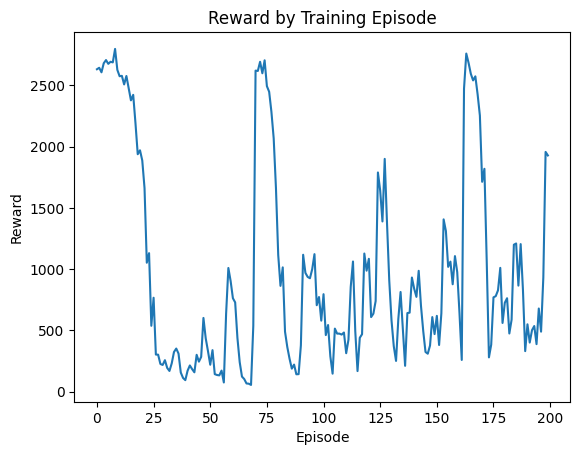

In [14]:
plt.title("Reward by Training Episode")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.plot(ending_ep_rewards)
plt.show()

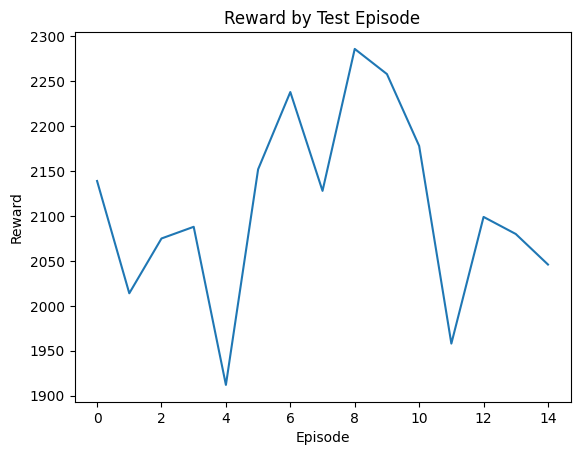

In [15]:
plt.figure()
plt.title("Reward by Test Episode")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.plot([stat['total_reward'] for stat in test_stats])
plt.show()

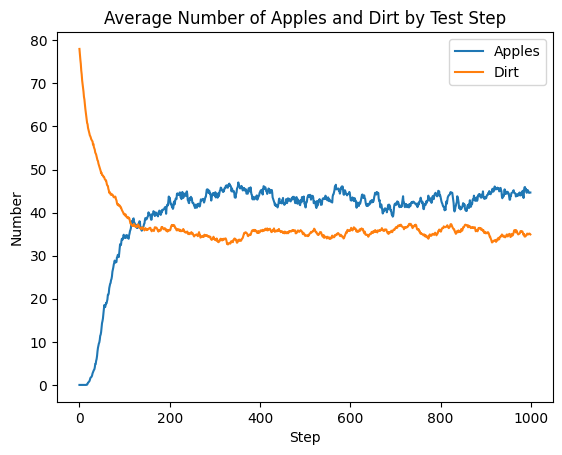

In [16]:
plt.figure()
plt.title("Average Number of Apples and Dirt by Test Step")
plt.xlabel("Step")
plt.ylabel("Number")
avg_num_apples = []
avg_num_dirt = []
for i in range(max_steps_per_episode):
    avg_num_apples.append(np.mean([stat['num_apples'][i] for stat in test_stats]))
    avg_num_dirt.append(np.mean([stat['num_dirt'][i] for stat in test_stats]))
plt.plot(avg_num_apples, label="Apples")
plt.plot(avg_num_dirt, label="Dirt")
plt.legend()
plt.show()

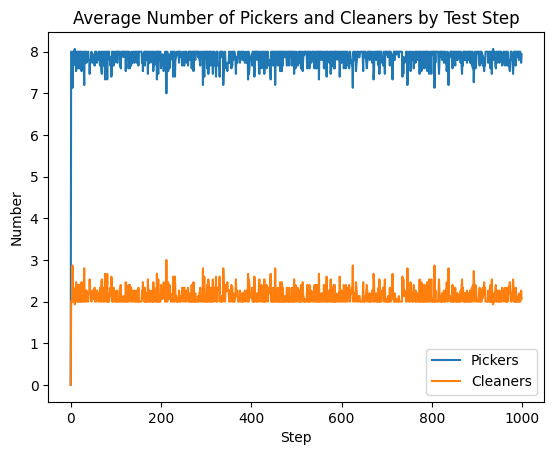

In [17]:
plt.figure()
plt.title("Average Number of Pickers and Cleaners by Test Step")
plt.xlabel("Step")
plt.ylabel("Number")
avg_num_pickers = []
avg_num_cleaners = []
for i in range(max_steps_per_episode):
    avg_num_pickers.append(np.mean([stat['pickers'][i] for stat in test_stats]))
    avg_num_cleaners.append(np.mean([stat['cleaners'][i] for stat in test_stats]))
plt.plot(avg_num_pickers, label="Pickers")
plt.plot(avg_num_cleaners, label="Cleaners")
plt.legend()
plt.show()

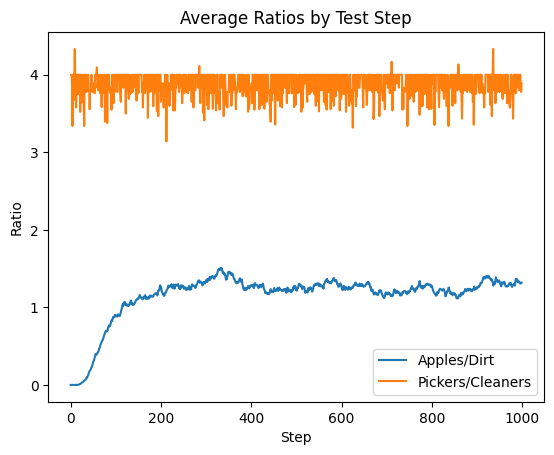

In [18]:
plt.figure()
plt.title("Average Ratios by Test Step")
plt.xlabel("Step")
plt.ylabel("Ratio")
avg_apple_dirt_ratios = []
apple_dirt_steps = []
avg_picker_cleaner_ratios = []
picker_cleaner_steps = []
for i in range(max_steps_per_episode):
    #avg_apple_dirt_ratios.append(np.mean([stat['num_apples'][i] / (stat['num_dirt'][i] + 1e-8) for stat in test_stats]))
    #avg_picker_cleaner_ratios.append(np.mean([stat['pickers'][i] / (stat['cleaners'][i]) for stat in test_stats if stat['cleaners'][i] > 0]))
    apple_dirt = []
    picker_cleaner = []
    for stat in test_stats:
        if stat['num_dirt'][i] > 0:
            apple_dirt.append(stat['num_apples'][i] / stat['num_dirt'][i])
        if stat['cleaners'][i] > 0:
            picker_cleaner.append(stat['pickers'][i] / stat['cleaners'][i])
    if len(apple_dirt) > 0:
        avg_apple_dirt_ratios.append(np.mean(apple_dirt))
        apple_dirt_steps.append(i)
    if len(picker_cleaner) > 0:
        avg_picker_cleaner_ratios.append(np.mean(picker_cleaner))
        picker_cleaner_steps.append(i)

plt.plot(apple_dirt_steps, avg_apple_dirt_ratios, label="Apples/Dirt")
plt.plot(picker_cleaner_steps, avg_picker_cleaner_ratios, label="Pickers/Cleaners")
plt.legend()
plt.show()